# 군집을 이용한 이미지 픽셀 분할

이미지 분할은 이미지의 픽셀을 비슷한 특성을 가진 여러 그룹으로 분류하는 과정입니다. 이를 위해 군집 알고리즘인 k-평균(K-means)이 널리 사용됩니다. k-평균 알고리즘은 각 픽셀의 색상 값을 벡터로 간주하고, 이를 기반으로 비슷한 색상의 픽셀을 같은 그룹으로 묶습니다.

In [1]:
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from PIL import Image

#img_path = './data/bird.png'
img_path = './data/colorful_house.jpg'
original_img = Image.open(img_path)
#original_img

In [2]:
# 이미지 데이터를 NumPy 배열로 변환하고, 각 픽셀 값을 [0, 1] 범위로 스케일링합니다.
original_img = np.array(original_img, dtype=np.float64) / 255 
original_img.shape

(694, 1000, 3)

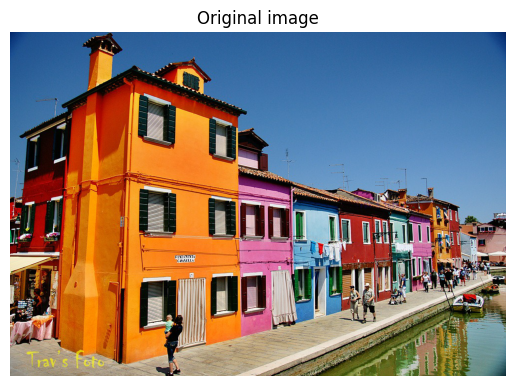

In [3]:
plt.imshow(original_img)
plt.axis('off')    
plt.title('Original image')
plt.show()

먼저 원본 이미지 데이터를 재구성하여 각 픽셀을 RGB 색상 공간의 점으로 취급합니다. 그런 다음, 원본 이미지 데이터의 1/10을 무작위로 샘플링하여 대표성 있는 데이터 세트를 생성합니다.

In [4]:
# original_img의 shape을 w(너비), h(높이), d(깊이)에 할당합니다.
# 이 경우, d는 이미지의 색상 채널 수를 의미 (RGB에서는 3).
w, h, d = tuple(original_img.shape)
print(w, h, d)

# assert 문은 d가 3인지 확인합니다. RGB 이미지의 경우 d는 3이어야 하며,
# 그렇지 않으면 코드가 중단됩니다.
assert d == 3

# 이미지 데이터를 2차원 배열로 재구성(reshape)합니다. 각 픽셀은 RGB 색상 공간에서 하나의 점으로 간주됩니다.
# 결과적으로 w*h는 픽셀 수를, d는 채널 수를 나타내게 됩니다.
image_array = np.reshape(original_img, (w * h, d))
print(image_array.shape)

# 원본 이미지 데이터의 1/10을 샘플링합니다. 샘플링은 데이터를 무작위로 섞은 후 선택하는 과정입니다.
# 이렇게 하면 이미지의 모든 부분을 고르게 대표할 수 있습니다. 또한, random_state=0을 설정함으로써 동일한 결과를 얻을 수 있습니다.
image_array_sample = shuffle(image_array, random_state=0)[:w * h // 10]
print(image_array_sample.shape)

694 1000 3
(694000, 3)
(69400, 3)


In [5]:
image_array_sample 

array([[0.65490196, 0.57254902, 0.39607843],
       [0.54901961, 0.49803922, 0.43137255],
       [0.32941176, 0.11372549, 0.13333333],
       ...,
       [0.03529412, 0.02352941, 0.        ],
       [0.24705882, 0.34117647, 0.04313725],
       [0.80392157, 0.42745098, 0.02745098]])

### K-means Clustering 모델 작성

- 이미지를 N 개의 양자화(quantized)된 색으로 표현
- 양자화는 연속적인 값을 불연속적인 단위로 나누는 과정을 의미

In [27]:
# 클러스터의 수를 정의
N_CLUSTERS = 4

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0, n_init='auto')
kmeans.fit(image_array_sample)
kmeans

KMeans(n_clusters=4, n_init='auto', random_state=0)

In [17]:
kmeans.cluster_centers_

array([[0.77319895, 0.693037  , 0.65260997],
       [0.27828174, 0.46755963, 0.65627129],
       [0.83494072, 0.43273098, 0.10760688],
       [0.19377819, 0.11709443, 0.07642137]])

각 픽셀에 대해 그 픽셀이 속한 클러스터의 중심값으로 픽셀 값을 설정함으로써 이미지를 재구성합니다.   
이렇게 하면 색상이 비슷한 픽셀들이 같은 색상으로 묶이게 되어 이미지가 분할됩니다.

In [20]:
# 각 픽셀을 가장 가까운 센터로 대체하여 이미지 양자화
labels = kmeans.predict(image_array)
print("label 갯수", labels.shape)
print("각 cluster 에 속한 label 갯수")
print(np.unique(labels, return_counts=True))

label 갯수 (694000,)
각 cluster 에 속한 label 갯수
(array([0, 1, 2, 3]), array([133680, 253499, 166868, 139953], dtype=int64))


In [21]:
# codebook은 각 클러스터의 중심값을 저장한 배열입니다.
codebook = kmeans.cluster_centers_
codebook

array([[0.77319895, 0.693037  , 0.65260997],
       [0.27828174, 0.46755963, 0.65627129],
       [0.83494072, 0.43273098, 0.10760688],
       [0.19377819, 0.11709443, 0.07642137]])

In [22]:
# d는 이미지의 채널 수를 나타냅니다 (RGB면 3, RGBA면 4).
d = codebook.shape[1]
d

3

In [23]:
# 새 이미지를 생성합니다. 각 픽셀은 초기에 0으로 설정됩니다.
image = np.zeros((w, h, d))
image.shape

(694, 1000, 3)

In [24]:
# label_idx는 현재 처리 중인 픽셀의 라벨을 가리키는 인덱스입니다.
label_idx = 0

# 이미지의 각 픽셀에 대해
for i in range(w):
    for j in range(h):
        # 해당 픽셀의 라벨에 해당하는 클러스터 중심값으로 이미지 픽셀 값을 설정
        image[i][j] = codebook[labels[label_idx]]
        # 다음 픽셀 라벨로 이동합니다.
        label_idx += 1

In [25]:
image.shape

(694, 1000, 3)

- N개의 color로 양자화된 새 image 시각화

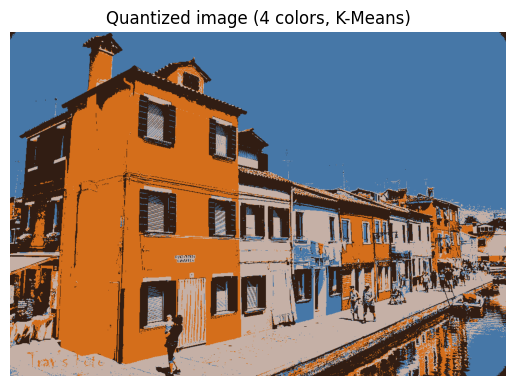

In [26]:
plt.figure()
plt.axis('off')
plt.title(f'Quantized image ({N_CLUSTERS} colors, K-Means)')
plt.imshow(image)
plt.show()